In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import csv
import pickle 
import copy 

import numpy as np
import random
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


import sys
sys.path.insert(0, "../utils/")
from utils import predictionPlots, extractData, writeResult, R2

import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredError
from keras.utils.generic_utils import get_custom_objects

from keras import backend as K

## Input options

In [3]:
features_names  = ['m1', 'm2', 's1x', 's1y', 's1z', 's2x', 's2y', 's2z', 'theta', 'q', 'Mc'];
regr_data_dir   = '../NewRealistic/'
write_output    = False
out_data_dir    = '../NNtf_results/'
versions        = ['0'] # can be a subset of ['0', '1', '2']
clabels         = ['0'] # can be a subset of ['0', '1']

# sample size (fixed, do not modify)
Ntrain          = 20000
Ntest           = 15000

# training options
epochs           = 250
validation_split = 0.2
batch_size       = 64
verbose_training = 1
hidden_layers    = 2
neurons          = [150, 150];
learning_rate    = 0.0001
scaler_str       = 'mixed'  # standard, minmax, mixed
activation       = 'relu'
out_activation   = 'linear_cut' # sigmoid, linear, linear_cut, linear_cut_T3

## Check on input and dictionary-initialization

In [4]:
Nfeatures  = len(features_names)

# define dictionary for each version considered
Nv       = len(versions)
Nc       = len(clabels)
Nsets    = Nv*Nc

if Nv*Nc!=Nsets:
    print('+++ Wrong input! +++')

datasets = {}
keys     = []
for i in range(0,Nv):
    version = versions[i]
    for j in range(0,Nc):
        clabel = clabels[j]
        key = 'v'+version+'c'+clabel
        keys.append(key)
        datasets[key]         = lambda:0
        datasets[key].clabel  = clabel
        datasets[key].version = version
        datasets[key].Ntrain  = Ntrain
        datasets[key].Ntest   = Ntest

In [5]:
# define the ouput activation according to the input
if out_activation=="sigmoid":
    def output_activation(x):
        return K.sigmoid(x)*2-1

elif out_activation=="linear":
    def output_activation(x):
        return x

elif out_activation=="linear_cut":
    def output_activation(x):
        signs = K.switch(x>0, 1+x*0, -1+x*0) # x*0 in order to broadcast to correct dimension
        return K.switch(abs(x)<1, x, signs)

elif out_activation=="linear_cut_T3":
    def output_activation(x):
        return 2/(K.exp(-(2*x+2/3*x*x*x))+1)-1

# define model
def buildModelUsingSequential(hidden_layers, neurons, batch_size, Nfeatures):
    if len(neurons)!=hidden_layers:
        print('The vector "neurons" has different length than "hidden_layers"')
        sys.exit()
    model = Sequential()
    for i in range(0, hidden_layers):
        model.add(Dense(neurons[i], kernel_initializer='normal', activation=activation))
    model.add(Dense(Nfeatures, kernel_initializer='normal', activation=output_activation))
    model.build((batch_size, Nfeatures))
    return model

mse = MeanSquaredError()

## Loop on versions

********************************************************************************
Key: v0c0
********************************************************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (64, 150)                 1800      
                                                                 
 dense_1 (Dense)             (64, 150)                 22650     
                                                                 
 dense_2 (Dense)             (64, 11)                  1661      
                                                                 
Total params: 26,111
Trainable params: 26,111
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
250/250 [==============================] - 1s 3ms/step - loss: 0.2302 - mean_squared_error: 0.2302 - accuracy: 0.3234 - val_loss: 0.

250/250 [==============================] - 1s 3ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - accuracy: 0.8783 - val_loss: 0.0156 - val_mean_squared_error: 0.0157 - val_accuracy: 0.8857
Epoch 37/250
250/250 [==============================] - 1s 2ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - accuracy: 0.8786 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_accuracy: 0.8890
Epoch 38/250
250/250 [==============================] - 1s 2ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - accuracy: 0.8805 - val_loss: 0.0152 - val_mean_squared_error: 0.0153 - val_accuracy: 0.8905
Epoch 39/250
250/250 [==============================] - 1s 2ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - accuracy: 0.8804 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_accuracy: 0.8865
Epoch 40/250
250/250 [==============================] - 1s 2ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - accuracy: 0.8819 - val_loss: 0.0154 - val_mean_squared_error: 0.0155 - val_

Epoch 76/250
250/250 [==============================] - 1s 2ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - accuracy: 0.8949 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_accuracy: 0.8955
Epoch 77/250
250/250 [==============================] - 0s 2ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - accuracy: 0.8964 - val_loss: 0.0124 - val_mean_squared_error: 0.0125 - val_accuracy: 0.8955
Epoch 78/250
250/250 [==============================] - 1s 2ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - accuracy: 0.8963 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_accuracy: 0.8945
Epoch 79/250
250/250 [==============================] - 1s 2ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - accuracy: 0.8964 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_accuracy: 0.8955
Epoch 80/250
250/250 [==============================] - 0s 2ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - accuracy: 0.8959 - val_loss: 0.0122 - val_mean_squared_error: 

Epoch 116/250
250/250 [==============================] - 1s 3ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - accuracy: 0.9043 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_accuracy: 0.9005
Epoch 117/250
250/250 [==============================] - 1s 3ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - accuracy: 0.9051 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_accuracy: 0.8963
Epoch 118/250
250/250 [==============================] - 1s 2ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - accuracy: 0.9052 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_accuracy: 0.9032
Epoch 119/250
250/250 [==============================] - 1s 2ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - accuracy: 0.9038 - val_loss: 0.0111 - val_mean_squared_error: 0.0112 - val_accuracy: 0.8980
Epoch 120/250
250/250 [==============================] - 1s 2ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - accuracy: 0.9049 - val_loss: 0.0110 - val_mean_squared_er

250/250 [==============================] - 1s 2ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - accuracy: 0.9084 - val_loss: 0.0106 - val_mean_squared_error: 0.0107 - val_accuracy: 0.8988
Epoch 156/250
250/250 [==============================] - 1s 2ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - accuracy: 0.9087 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_accuracy: 0.9043
Epoch 157/250
250/250 [==============================] - 1s 2ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - accuracy: 0.9084 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_accuracy: 0.9035
Epoch 158/250
250/250 [==============================] - 1s 3ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - accuracy: 0.9090 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_accuracy: 0.9018
Epoch 159/250
250/250 [==============================] - 1s 2ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - accuracy: 0.9085 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - 

Epoch 195/250
250/250 [==============================] - 0s 2ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - accuracy: 0.9096 - val_loss: 0.0097 - val_mean_squared_error: 0.0098 - val_accuracy: 0.9075
Epoch 196/250
250/250 [==============================] - 0s 2ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - accuracy: 0.9101 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_accuracy: 0.9070
Epoch 197/250
250/250 [==============================] - 0s 2ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - accuracy: 0.9112 - val_loss: 0.0099 - val_mean_squared_error: 0.0100 - val_accuracy: 0.9072
Epoch 198/250
250/250 [==============================] - 0s 2ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - accuracy: 0.9101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_accuracy: 0.9003
Epoch 199/250
250/250 [==============================] - 0s 2ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - accuracy: 0.9116 - val_loss: 0.0096 - val_mean_squared_er

250/250 [==============================] - 1s 2ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - accuracy: 0.9113 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_accuracy: 0.9070
Epoch 235/250
250/250 [==============================] - 1s 2ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - accuracy: 0.9127 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_accuracy: 0.9057
Epoch 236/250
250/250 [==============================] - 0s 2ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - accuracy: 0.9111 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_accuracy: 0.9057
Epoch 237/250
250/250 [==============================] - 0s 2ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - accuracy: 0.9112 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_accuracy: 0.9078
Epoch 238/250
250/250 [==============================] - 1s 2ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - accuracy: 0.9112 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - 

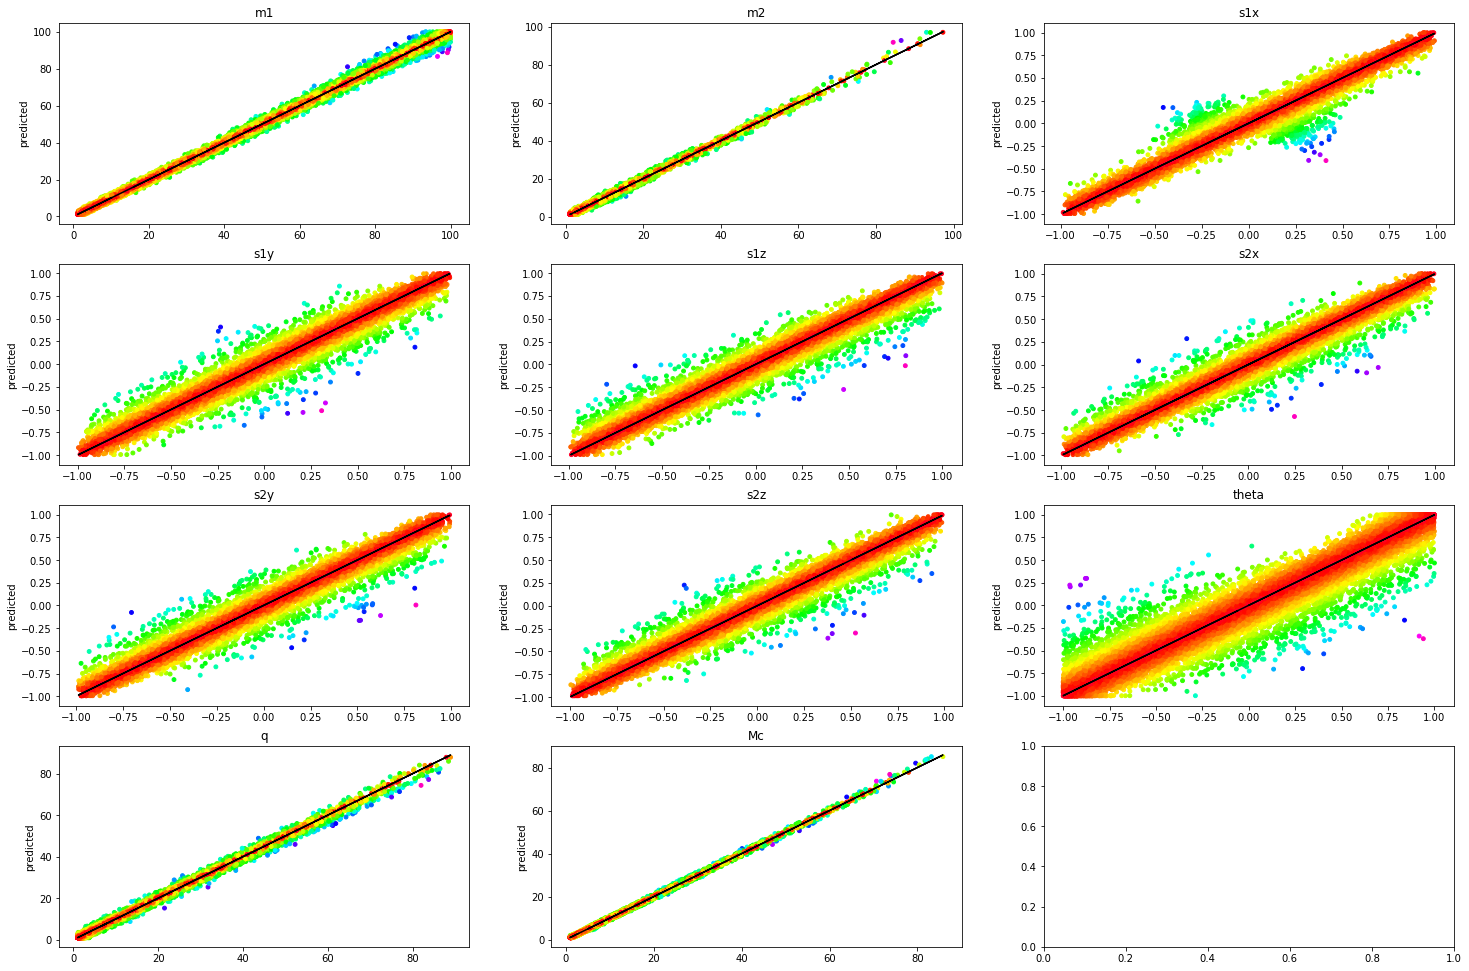

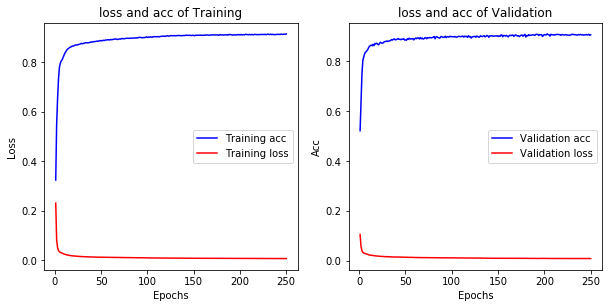

In [6]:
dashes = '*'*80

for key in keys:
    print(dashes, '\nKey: ', key, '\n', dashes, sep='')
        
    # Load all the data for the specific version
    xtrain_notnormalized = extractData(regr_data_dir+key+'train_x.csv', verbose=False)
    ytrain_notnormalized = extractData(regr_data_dir+key+'train_y.csv', verbose=False)
    xtest_notnormalized  = extractData(regr_data_dir+key+'test_x.csv' , verbose=False)
    ytest_notnormalized  = extractData(regr_data_dir+key+'test_y.csv' , verbose=False)
    
    # rescale
    if scaler_str=="standard":
        scaler_x = StandardScaler().fit(xtrain_notnormalized)
        scaler_y = StandardScaler().fit(ytrain_notnormalized)
    elif scaler_str=="minmax":
        scaler_x = MinMaxScaler(feature_range=(-1, 1)).fit(xtrain_notnormalized)
        scaler_y = MinMaxScaler(feature_range=(-1, 1)).fit(ytrain_notnormalized)
    elif scaler_str=="mixed":
        scaler_x = StandardScaler().fit(xtrain_notnormalized)
        scaler_y = MinMaxScaler(feature_range=(-1, 1)).fit(ytrain_notnormalized)
    else:
        print('scaler "',scaler_str,'" not recognized!',sep='')
        sys.exit()
        
    xtrain   = scaler_x.transform(xtrain_notnormalized)
    ytrain   = scaler_y.transform(ytrain_notnormalized)
    xtest    = scaler_x.transform(xtest_notnormalized)
    ytest    = scaler_y.transform(ytest_notnormalized)
    

    # build the model
    model = buildModelUsingSequential(hidden_layers, neurons, batch_size, Nfeatures)

    # compile 
    model.compile(
        loss=mse, 
        optimizer=Adam(learning_rate=learning_rate), 
        metrics=[mse, 'accuracy']
    )
    
    model.summary()
    
    # train the model
    t0 = time.perf_counter()
    history = model.fit(xtrain, ytrain, 
        epochs           = epochs, 
        batch_size       = batch_size,
        validation_split = validation_split,
        verbose          = verbose_training
    )
    train_time = time.perf_counter()-t0
    
    # predict
    ypredicted = model.predict(xtest)
    
    R2_vec = np.zeros((Nfeatures,))
    for i in range(0,Nfeatures):
         R2_vec[i] = R2(ytest[:,i], ypredicted[:,i])
    
    # print some information
    metrics_dict    = {};
    metrics_results = model.evaluate(xtest, ytest, verbose=0)
    metrics_dict["loss"]   = metrics_results[0]
    metrics_dict["mse"]    = metrics_results[1]
    metrics_dict["acc"]    = metrics_results[2]
    metrics_dict["R2"]     = R2_vec
    metrics_dict["R2mean"] = np.mean(R2_vec)
    
    print('\nFinal loss     :', metrics_dict["loss"])
    print('Final mse      :', metrics_dict["mse"])
    print('Final accuracy :', metrics_dict["acc"])
    print('Final R2 mean  :', metrics_dict["R2mean"])
    for i in range(0,Nfeatures):
        print('R2[{:2d}]         : {:.5f}'.format(i,metrics_dict["R2"][i]))
        
    # update dictionary adding data (both normalized and not), model and score
    datasets[key].train_time = train_time
    datasets[key].model      = model
    datasets[key].history    = history
    datasets[key].predicted  = scaler_y.inverse_transform(ypredicted)
    datasets[key].metrics    = metrics_dict
    
    # plot
    predictionPlots(scaler_y.inverse_transform(ytest), 
                scaler_y.inverse_transform(ypredicted), 
                features_names)
    
    del model
    
    # plot history 
    history_dict = history.history

    acc      = history_dict['accuracy']
    val_acc  = history_dict['val_accuracy']
    loss     = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs_plot=range(1,epochs+1)    
    plt.figure(figsize=(10,10))

    ax1=plt.subplot(221)
    ax1.plot(epochs_plot,acc,'b',label='Training acc')
    ax1.plot(epochs_plot,loss,'r',label='Training loss')
    ax1.set_title('loss and acc of Training')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2=plt.subplot(222)
    ax2.plot(epochs_plot,val_acc,'b',label='Validation acc')
    ax2.plot(epochs_plot,val_loss,'r',label='Validation loss')
    ax2.set_title('loss and acc of Validation')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Acc')
    ax2.legend()
    
    plt.show()

## Produce CSV files

In [7]:
if write_output:
    for key in keys:
        # save csv
        filename = out_data_dir+'NN_tf_'+key+'.csv'
        writeResult(filename, datasets[key].predicted, verbose=True)
        
        # save model
        #dict_name = out_data_dir+'NN_tf_'+key+'.dict'
        #pickle.dump(datasets[key].model, open(dict_name, 'wb'))
        #print(dict_name, 'saved') 
        
        # example for loading models
        #dict_name    = out_data_dir+'NN_tf_'+key+'.dict'
        #print('Loading', dict_name, '...')
        #loaded_model = pickle.load(open(dict_name, 'rb'))